In [87]:
## pip install xgboost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np


In [3]:
combined_stats = pd.read_csv('Data/FantasyFootball_2025.csv')

In [5]:
combined_stats.head()

,ID,Player,Tm,FantPos,2023Age,2023G,2023Cmp,2023Att,PassYds,2023PassTD,...,2025Int,2025RushAtt,2025RushYds,2025RushTD,2025Rec,2025RecYds,2025RecTD,2025FL,2025TD,2025PPR
0,6,Lamar Jackson,BAL,QB,26,16,307,457,3678,24,...,6,148.0,952,4,0,0,0,5,40,479.2
1,21,Ja'Marr Chase,CIN,WR,23,16,1,1,-7,0,...,0,3.0,21,0,119,1607,14,0,14,367.1
2,1,Josh Allen,BUF,QB,27,17,385,579,4306,29,...,6,113.0,561,10,0,0,0,2,41,431.3
3,11,Joe Burrow,CIN,QB,27,10,244,365,2309,15,...,9,44.0,190,3,0,0,0,4,42,439.1
4,26,Baker Mayfield,TAM,QB,28,17,364,566,4044,28,...,18,61.0,326,3,0,0,0,3,38,389.7


In [7]:
combined_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 66 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           281 non-null    int64  
 1   Player                       281 non-null    object 
 2   Tm                           237 non-null    object 
 3   FantPos                      281 non-null    object 
 4   2023Age                      281 non-null    int64  
 5   2023G                        281 non-null    int64  
 6   2023Cmp                      281 non-null    int64  
 7   2023Att                      281 non-null    int64  
 8   PassYds                      281 non-null    int64  
 9   2023PassTD                   281 non-null    int64  
 10  2023Int                      281 non-null    int64  
 11  2023RushAtt                  281 non-null    int64  
 12  2023RushYds                  281 non-null    int64  
 13  2023RushTD          

In [60]:
combined_stats.groupby('FantPos')['2025PPR'].describe()

,count,mean,std,min,25%,50%,75%,max
FantPos,,,,,,,,
QB,38.0,284.184211,121.760020,15.7,270.55,315.30,356.350,479.2
RB,88.0,141.922727,81.358714,35.3,82.05,125.60,192.450,316.9
TE,46.0,137.006522,50.743868,54.4,104.60,129.85,164.775,262.6
WR,109.0,176.338532,63.752098,0.0,131.00,159.40,219.100,367.1


In [9]:
# Convert columns to numeric, handling errors
numeric_columns = [
    '2024PassYds', '2024RushYds', '2024RecYds'
]

In [11]:
for col in numeric_columns:
    combined_stats[col] = pd.to_numeric(combined_stats[col], errors='coerce')

In [43]:

def train_and_predict(position, features):
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()
    
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

    X = position_data[features].fillna(0)
    y = position_data['2025PPR'].fillna(0)

    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    position_data = position_data.reset_index(drop=True)

    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, position_data.index, test_size=0.2, random_state=42
    )

    position_data.loc[idx_train, 'Data Split'] = 'Train'
    position_data.loc[idx_test, 'Data Split'] = 'Test'

    # XGBoost model
    xgb = XGBRegressor(
        n_estimators=150,
        max_depth=2,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bynode=0.8,
        reg_alpha=0.1,
        reg_lambda=1,
        random_state=42
    )
    xgb.fit(X_train, y_train)

    y_pred_train = xgb.predict(X_train)
    y_pred_test = xgb.predict(X_test)

    print(f"\n{position} - Training MAE: {mean_absolute_error(y_train, y_pred_train)}")
    print(f"{position} - Testing MAE: {mean_absolute_error(y_test, y_pred_test)}")

    feature_importances = xgb.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    position_data['Predicted Fantasy Points'] = xgb.predict(X)
    
    return position_data[['Player', 'Data Split', 'FantPos', 'Predicted Fantasy Points', '2025PPR']]

# Define feature sets for each position, including past PPR points and new features (2023/2024Avg was not added in the features)
rb_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023G', '2023FL', '2023TD', '2024G', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age']
wr_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023G', '2023FL', '2023TD', '2024G', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age']
te_features = ['2023Rec', '2023RecTD', '2023G', '2023FL', '2023TD', '2024G', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', '2024PPR', 'HealthGrade', '2025Age']
qb_features = ['PassYds', '2023PassTD', '2023RushAtt', '2023RushYds', '2023RushTD', '2023G', '2023FL', '2023TD', '2024G', '2024RushAtt', '2024RushYds', '2024RushTD', '2024FL', '2024PassYds', '2024PassTD', 'HealthGrade', '2025Age']

rb_predictions = train_and_predict('RB', rb_features)
wr_predictions = train_and_predict('WR', wr_features)
te_predictions = train_and_predict('TE', te_features)
qb_predictions = train_and_predict('QB', qb_features)

all_predictions = pd.concat([rb_predictions, wr_predictions, te_predictions, qb_predictions]).round(2)

output_path = "Data/FantasyFootballPrediction_XGB.csv"
all_predictions[['Player', 'Data Split', 'FantPos', 'Predicted Fantasy Points', '2025PPR']].to_csv(output_path, index=False)


RB - Training MAE: 6.451536843436102
RB - Testing MAE: 28.169424841139055

RB - Feature Importances:
        Feature  Importance
11   2024RushTD    0.283555
9   2024RushAtt    0.154186
13   2024RecYds    0.099483
1   2023RushYds    0.075321
0   2023RushAtt    0.072415
14    2024RecTD    0.050322
3       2023Rec    0.041289
8         2024G    0.035406
10  2024RushYds    0.032288
7        2023TD    0.030173
12      2024Rec    0.021828
2    2023RushTD    0.020763
5         2023G    0.019597
4     2023RecTD    0.018943
17      2025Age    0.014869
6        2023FL    0.011991
15       2024FL    0.010120
16  HealthGrade    0.007451

WR - Training MAE: 8.470779967034
WR - Testing MAE: 22.68358542702415

WR - Feature Importances:
        Feature  Importance
12      2024Rec    0.264651
14    2024RecTD    0.097147
3       2023Rec    0.077089
15       2024FL    0.062022
2    2023RushTD    0.061394
8         2024G    0.055871
17      2025Age    0.047838
13   2024RecYds    0.046674
1   2023RushYds 

In [49]:
# Evaluate R² and MAE by position
position_metrics = []

for pos in all_predictions['FantPos'].unique():
    subset = all_predictions[all_predictions['FantPos'] == pos]
    r2 = r2_score(subset['2025PPR'], subset['Predicted Fantasy Points'])
    mae = mean_absolute_error(subset['2025PPR'], subset['Predicted Fantasy Points'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

# Convert to DataFrame for easy viewing
position_metrics_df = pd.DataFrame(position_metrics)

print("\nPerformance Metrics by Position:")
print(position_metrics_df)


Performance Metrics by Position:
  Position     R²    MAE
0       RB  0.952  10.89
1       WR  0.923  11.34
2       TE  0.968   5.32
3       QB  0.821  21.86


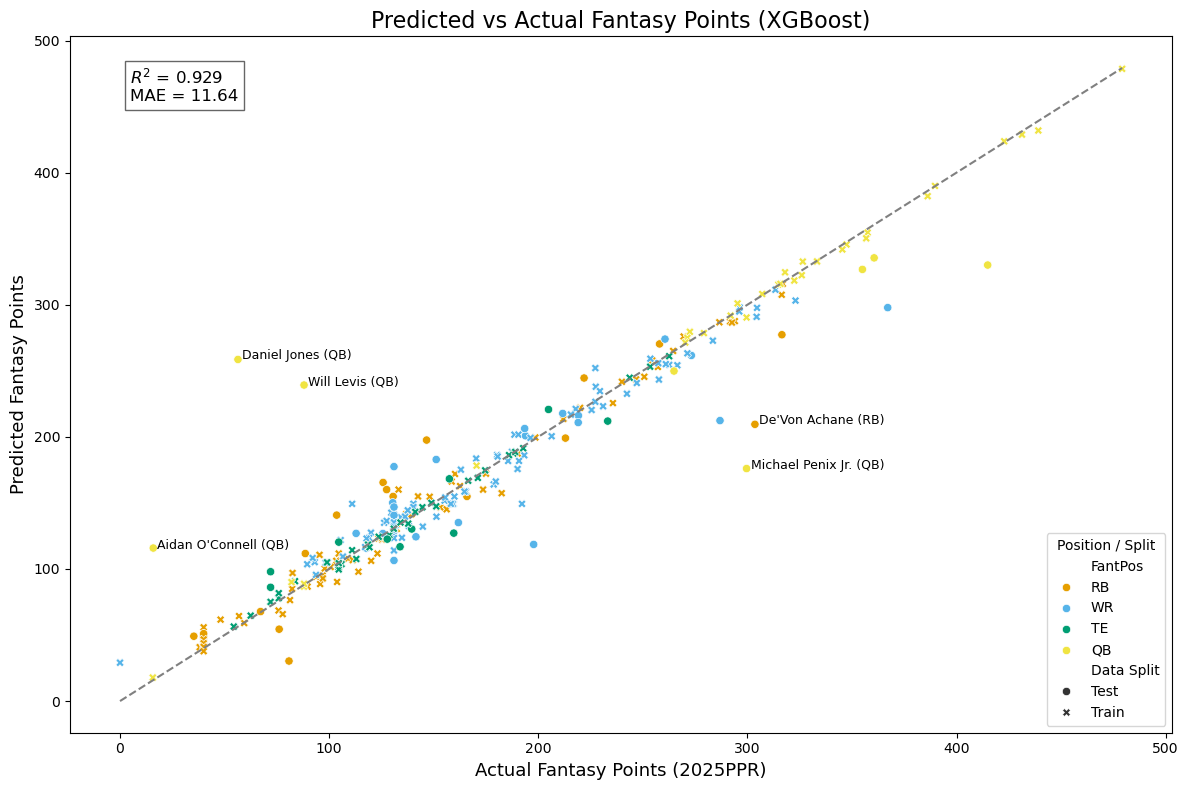

In [51]:
# Calculate metrics
r2 = r2_score(all_predictions['2025PPR'], all_predictions['Predicted Fantasy Points'])
mae = mean_absolute_error(all_predictions['2025PPR'], all_predictions['Predicted Fantasy Points'])

# Calculate residuals
all_predictions['Residual'] = np.abs(all_predictions['2025PPR'] - all_predictions['Predicted Fantasy Points'])

# Get top 5 outliers
top_outliers = all_predictions.nlargest(5, 'Residual')

# Colorblind-friendly palette (Color Universal Design)
color_palette = {
    'RB': '#E69F00',  # orange
    'WR': '#56B4E9',  # blue
    'TE': '#009E73',  # green
    'QB': '#F0E442'   # yellow
}

# Plotting
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=all_predictions,
    x='2025PPR',
    y='Predicted Fantasy Points',
    hue='FantPos',
    style='Data Split',
    palette=color_palette
)

# Diagonal line for reference (perfect prediction)
min_val = min(all_predictions['2025PPR'].min(), all_predictions['Predicted Fantasy Points'].min())
max_val = max(all_predictions['2025PPR'].max(), all_predictions['Predicted Fantasy Points'].max())
plt.plot([min_val, max_val], [min_val, max_val], ls="--", color='gray')

# Annotate top residual outliers
for _, row in top_outliers.iterrows():
    plt.text(row['2025PPR'] + 2, row['Predicted Fantasy Points'],
             f"{row['Player']} ({row['FantPos']})", fontsize=9, color='black')

# Labels and title
plt.title('Predicted vs Actual Fantasy Points (XGBoost)', fontsize=16)
plt.xlabel('Actual Fantasy Points (2025PPR)', fontsize=13)
plt.ylabel('Predicted Fantasy Points', fontsize=13)

# Display R² and MAE on the plot
plt.text(min_val + 5, max_val - 25,
         f"$R^2$ = {r2:.3f}\nMAE = {mae:.2f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.6))

# Legend and layout
plt.legend(title='Position / Split', loc='lower right')
plt.tight_layout()
plt.show()

## XGBoost and Cross Validation Applied

In [54]:
import xgboost as xgb

def train_and_predict(position, features):
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()
    
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

    X = position_data[features].fillna(0)
    y = position_data['2025PPR'].fillna(0)

    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    position_data = position_data.reset_index(drop=True)

    # Prepare DMatrix for cross-validation
    dmatrix = xgb.DMatrix(X, label=y)

    params = {
    "objective": "reg:squarederror",
    "max_depth": 3,  # Lower depth
    "learning_rate": 0.1,
    "lambda": 1,  # Add regularization
    "alpha": 0.1,
    "seed": 42,
    "eval_metric": "mae"
    }

    print(f"\nPerforming cross-validation for {position}...")
    cv_results = xgb.cv(
        params=params,
        dtrain=dmatrix,
        nfold=5,
        num_boost_round=300,
        early_stopping_rounds=10,
        metrics="mae",
        seed=42,
        verbose_eval=False
    )

    best_n_rounds = cv_results['test-mae-mean'].idxmin()
    print(f"{position} - Best MAE: {cv_results['test-mae-mean'].min():.4f} at {best_n_rounds} rounds")

    # Train final model on full data using best number of boosting rounds
    model = xgb.train(params, dmatrix, num_boost_round=best_n_rounds)

    # Get predictions
    position_data['Predicted Fantasy Points'] = model.predict(dmatrix)

    # No actual "train/test" split here since we're using CV, but split for labeling is possible and optional
    _, _, _, _, idx_train, idx_test = train_test_split(X, y, position_data.index, test_size=0.2, random_state=42)
    position_data.loc[idx_train, 'Data Split'] = 'Train'
    position_data.loc[idx_test, 'Data Split'] = 'Test'

    return position_data[['Player', 'Data Split', 'FantPos', 'Predicted Fantasy Points', '2025PPR']]

# Define feature sets for each position, including past PPR points and new features (2023/2024Avg was not added in the features)
rb_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023G', '2023FL', '2023TD', '2024G', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age']
wr_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023G', '2023FL', '2023TD', '2024G', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age']
te_features = ['2023Rec', '2023RecTD', '2023G', '2023FL', '2023TD', '2024G', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', '2024PPR', 'HealthGrade', '2025Age']
qb_features = ['PassYds', '2023PassTD', '2023RushAtt', '2023RushYds', '2023RushTD', '2023G', '2023FL', '2023TD', '2024G', '2024RushAtt', '2024RushYds', '2024RushTD', '2024FL', '2024PassYds', '2024PassTD', 'HealthGrade', '2025Age']

rb_predictions = train_and_predict('RB', rb_features)
wr_predictions = train_and_predict('WR', wr_features)
te_predictions = train_and_predict('TE', te_features)
qb_predictions = train_and_predict('QB', qb_features)

all_predictions = pd.concat([rb_predictions, wr_predictions, te_predictions, qb_predictions]).round(2)

output_path = "Data/FantasyFootballPrediction_XGB_CV.csv"
all_predictions[['Player', 'Data Split', 'FantPos', 'Predicted Fantasy Points', '2025PPR']].to_csv(output_path, index=False)


Performing cross-validation for RB...
RB - Best MAE: 34.8425 at 32 rounds

Performing cross-validation for WR...
WR - Best MAE: 31.9718 at 37 rounds

Performing cross-validation for TE...
TE - Best MAE: 24.3278 at 25 rounds

Performing cross-validation for QB...
QB - Best MAE: 79.8116 at 27 rounds


In [56]:
# Evaluate R² and MAE by position
position_metrics = []

for pos in all_predictions['FantPos'].unique():
    subset = all_predictions[all_predictions['FantPos'] == pos]
    r2 = r2_score(subset['2025PPR'], subset['Predicted Fantasy Points'])
    mae = mean_absolute_error(subset['2025PPR'], subset['Predicted Fantasy Points'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

# Convert to DataFrame for easy viewing
position_metrics_df = pd.DataFrame(position_metrics)

print("\nPerformance Metrics by Position:")
print(position_metrics_df)


Performance Metrics by Position:
  Position     R²    MAE
0       RB  0.959  12.83
1       WR  0.929  12.38
2       TE  0.942   9.29
3       QB  0.948  20.18


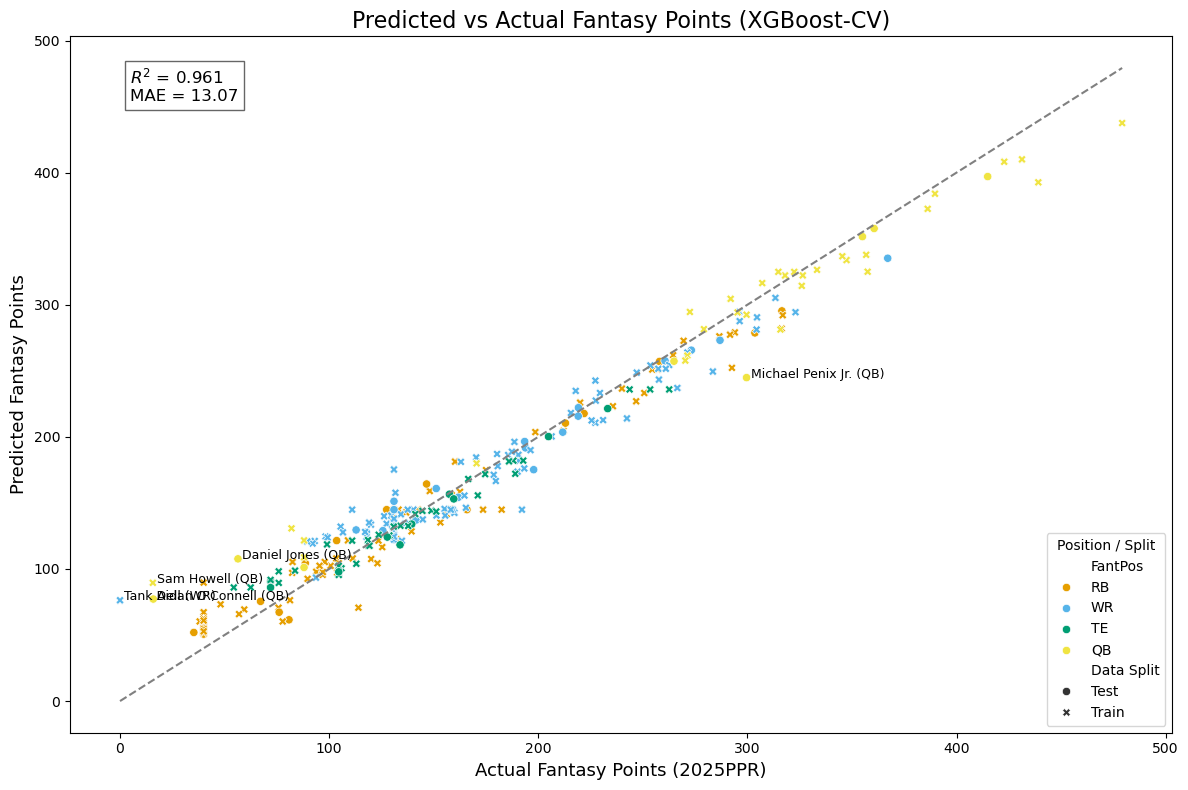

In [58]:
# Calculate metrics
r2 = r2_score(all_predictions['2025PPR'], all_predictions['Predicted Fantasy Points'])
mae = mean_absolute_error(all_predictions['2025PPR'], all_predictions['Predicted Fantasy Points'])

# Calculate residuals
all_predictions['Residual'] = np.abs(all_predictions['2025PPR'] - all_predictions['Predicted Fantasy Points'])

# Get top 5 outliers
top_outliers = all_predictions.nlargest(5, 'Residual')

# Colorblind-friendly palette (Color Universal Design)
color_palette = {
    'RB': '#E69F00',  # orange
    'WR': '#56B4E9',  # blue
    'TE': '#009E73',  # green
    'QB': '#F0E442'   # yellow
}

# Plotting
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=all_predictions,
    x='2025PPR',
    y='Predicted Fantasy Points',
    hue='FantPos',
    style='Data Split',
    palette=color_palette
)

# Diagonal line for reference (perfect prediction)
min_val = min(all_predictions['2025PPR'].min(), all_predictions['Predicted Fantasy Points'].min())
max_val = max(all_predictions['2025PPR'].max(), all_predictions['Predicted Fantasy Points'].max())
plt.plot([min_val, max_val], [min_val, max_val], ls="--", color='gray')

# Annotate top residual outliers
for _, row in top_outliers.iterrows():
    plt.text(row['2025PPR'] + 2, row['Predicted Fantasy Points'],
             f"{row['Player']} ({row['FantPos']})", fontsize=9, color='black')

# Labels and title
plt.title('Predicted vs Actual Fantasy Points (XGBoost-CV)', fontsize=16)
plt.xlabel('Actual Fantasy Points (2025PPR)', fontsize=13)
plt.ylabel('Predicted Fantasy Points', fontsize=13)

# Display R² and MAE on the plot
plt.text(min_val + 5, max_val - 25,
         f"$R^2$ = {r2:.3f}\nMAE = {mae:.2f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.6))

# Legend and layout
plt.legend(title='Position / Split', loc='lower right')
plt.tight_layout()
plt.show()